In [1]:

CUDA_LAUNCH_BLOCKING=1
import torch
import torch.nn as nn
import numpy as np 


import random

import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:6")

H = torch.load("./test/original_weights.pt")["H"].to(device).float()
weights = torch.load("./test/original_weights.pt")["weights"].to(device).float()    

In [3]:
weights = weights
weights.shape

torch.Size([4096, 4096])

In [4]:
weights_norm = torch.norm(weights, dim=1)
weights_normalized = weights / weights_norm[:, None]

In [5]:
low_rank = 512

U, S, V = torch.svd(weights)

# print(U.shape, S.shape, V.shape)
A_orig = U[:, :low_rank] @ torch.sqrt(torch.diag(S[:low_rank]))
B_orig = torch.sqrt(torch.diag(S[:low_rank])) @ V[:, :low_rank].t()

weights_recov = A_orig @ B_orig * weights_norm[:, None]
print(torch.mean((weights - weights_recov)**2)/torch.mean(weights**2))


tensor(4.2827, device='cuda:6')


In [6]:
loggers = {}

In [7]:
#fine tune to fit
lr = 1e-4

A = A_orig.clone().requires_grad_()
B = B_orig.clone().requires_grad_()
optimizer = torch.optim.Adam([A, B], lr=lr) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma = 0.9)

losses = []
prev_loss = 1e9


for i in range(1000):
    optimizer.zero_grad()
    diff = weights - A @ B
    # print(diff.shape)
    # print(H.shape)
    loss = torch.einsum("ij,jk,ik->", diff, H/H.shape[0], diff)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i % 100 == 0:
        print(loss.item())
    
    if loss.item() > prev_loss:
        scheduler.step()
print(loss.item())
loggers[lr] = losses

1.2014673948287964
0.24024926126003265
0.21105903387069702
0.19836141169071198
0.19127815961837769
0.18686622381210327
0.18390044569969177
0.1818702220916748
0.18039536476135254
0.17933788895606995
0.17856086790561676


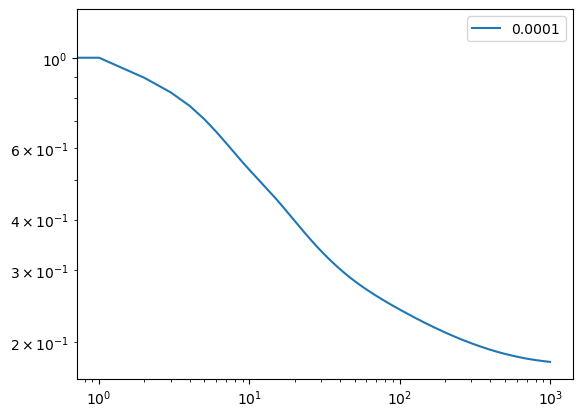

In [8]:
for lr, losses in loggers.items():
    plt.plot(losses, label=str(lr)) 

plt.yscale("log")
plt.legend()  
plt.xscale("log")  

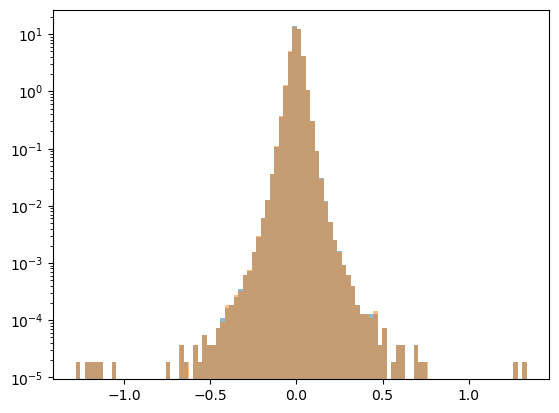

In [9]:
# plt.hist(weights.flatten().cpu().numpy(), bins=100, alpha=0.5, label="weights",
#             density=True)
plt.hist(B.flatten().detach().cpu().numpy(), bins=100, alpha=0.5, label="A",
            density=True)
plt.hist(B_orig.flatten().detach().cpu().numpy(), bins=100, alpha=0.5, label="B",
          density=True)
plt.yscale("log")

In [10]:
A = A.detach()
B = B.detach()

In [11]:
A_norm = torch.norm(A, dim=1)
B_norm = torch.norm(B, dim=0)

A_normalized = A / A_norm[:, None]
B_normalized = B / B_norm[None, :]

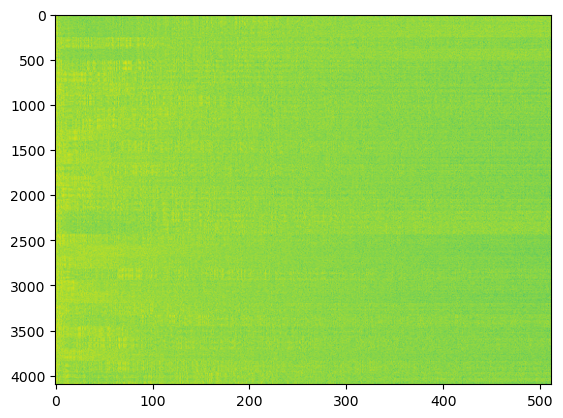

In [12]:
plt.imshow(np.log(np.abs(A_normalized.cpu().detach().numpy())), aspect="auto")

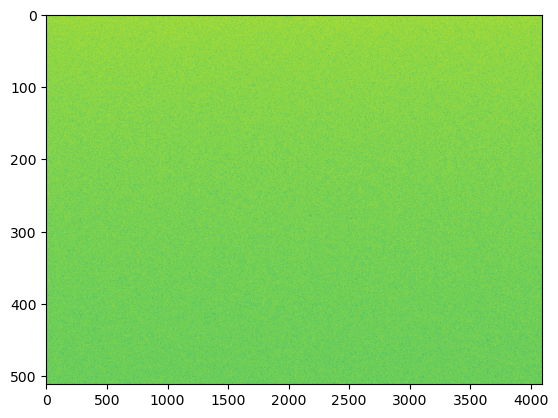

In [13]:
plt.imshow(np.log(np.abs(B_normalized.cpu().detach().numpy())), aspect="auto")

In [14]:
print("n bits per value:", 16 * (A.numel() + B.numel()) / weights.numel())  

n bits per value: 4.0


In [15]:
import sklearn.cluster as cluster

In [280]:
d = 4
n_bits_per_value = 2
n_centriods = 2**(d*n_bits_per_value)

#cluster A
A_cluster = cluster.KMeans(n_clusters=n_centriods, n_init=1,
                                        max_iter = 1).fit(A.reshape(-1, d).cpu().numpy(),None)

A_assignments = A_cluster.labels_
A_centriods = A_cluster.cluster_centers_

#cluster B
B_cluster = cluster.KMeans(n_clusters=n_centriods, n_init=1,
                                        max_iter = 1).fit(B.reshape(-1, d).cpu().numpy(),None)

B_assignments = B_cluster.labels_
B_centriods = B_cluster.cluster_centers_


In [281]:
A_quantized = torch.from_numpy(A_centriods[A_assignments]).reshape(A.shape).to(device) # * A_norm[:, None]
B_quantized = torch.from_numpy(B_centriods[B_assignments]).reshape(B.shape).to(device) # * B_norm[None, :]


weights_quantized = A_quantized @ B_quantized

diff = weights - weights_quantized
print(torch.mean(diff**2)/torch.mean(weights**2))
print(torch.einsum("ij,jk,ik->", diff, H/H.shape[0], diff))

tensor(0.2810, device='cuda:6')
tensor(505.7338, device='cuda:6')


In [282]:
A_centriods = torch.from_numpy(A_centriods).to(device)
B_centriods = torch.from_numpy(B_centriods).to(device)

In [283]:
#get the column rank of B
B_rank = torch.linalg.matrix_rank(B_quantized)
B_rank

tensor(512, device='cuda:6')

In [284]:
A.shape

torch.Size([4096, 512])

In [285]:
def random_estimate_smallest_eig(matrix,n_samples = 100):
    torch.random.manual_seed(0)
    
    x = torch.randn(n_samples,matrix.shape[1]).to(device)
    return torch.min(torch.einsum("ij,jk,ik->i", x, matrix, x) / torch.norm(x, dim=1)**2)

def random_estimate_largest_eig(matrix,n_samples = 100):
    torch.random.manual_seed(0)
    
    x = torch.randn(n_samples,matrix.shape[1]).to(device)
    return torch.max(torch.einsum("ij,jk,ik->i", x, matrix, x) / torch.norm(x, dim=1)**2)

random_estimate_smallest_eig(A.T @ H @ A, n_samples=10000), random_estimate_largest_eig(A.T @ H @ A, n_samples=10000)

(tensor(14.9246, device='cuda:6'), tensor(282.6154, device='cuda:6'))

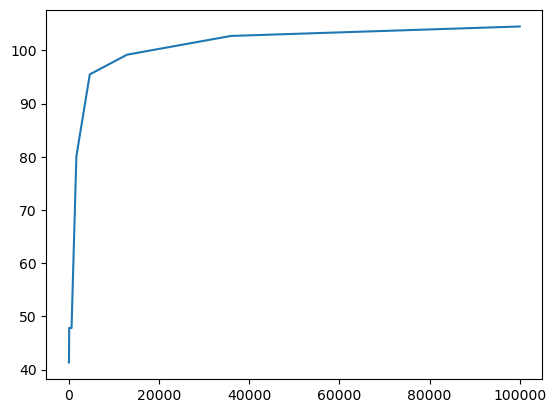

In [286]:
n_samples = np.logspace(1, 5, 10).astype(int)
eigs = []
for n in n_samples:
    eigs.append(random_estimate_largest_eig(H, n_samples=n).item())
plt.plot(n_samples, eigs)

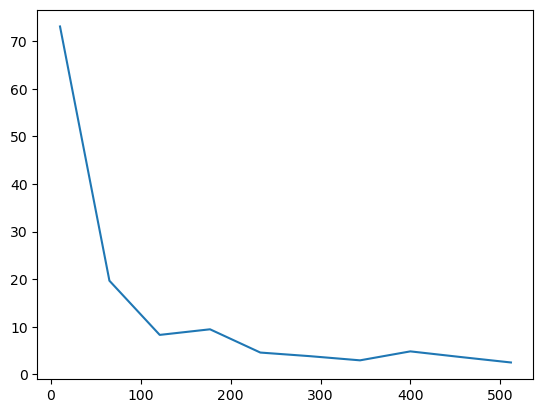

In [287]:
n_samples = np.logspace(1, 4, 10).astype(int)
eigs = []
x = B @ H/H.shape[0]@ B.T
n_ = np.linspace(10,x.shape[0],10).astype(int)
for n in n_:
    eigs.append(random_estimate_largest_eig(x[:n,:n], n_samples=1000).item())
plt.plot(n_, eigs)
# plt.yscale("log")
# plt.xscale("log")

In [288]:
A_assignments = torch.from_numpy(A_assignments).to(device)
B_assignments = torch.from_numpy(B_assignments).to(device)

In [289]:
#get the gradients
def p_tune(A:torch.Tensor,B:torch.Tensor,
           H:torch.Tensor,orig_weight:torch.Tensor, lr,
           A_assignments:torch.Tensor,
           B_assignments:torch.Tensor,
           A_centriods:torch.Tensor,
        B_centriods:torch.Tensor):
    
    diff = orig_weight - A @ B
    loss = torch.einsum("ij,jk,ik->", diff, H, diff)
    
    loss.backward()
    with torch.no_grad():
        #accumulate the gradients
        A_grad = A.grad.clone().reshape(-1, d)
        B_grad = B.grad.clone().reshape(-1, d)
        
        #zero the gradients
        A.grad.zero_()
        B.grad.zero_()
        
        #gather by the assignments
        for i in range(A_centriods.shape[0]):
            mask = A_assignments == i
            A_centriods[i] -= lr * A_grad[mask].mean(dim=0)
            
        for i in range(B_centriods.shape[0]):
            mask = B_assignments == i
            B_centriods[i] -= lr * B_grad[mask].mean(dim=0)
            
    
    return A_grad.reshape(A.shape), B_grad.reshape(B.shape), loss.item()

@torch.no_grad()
def v_tune_A(A:torch.Tensor, #
           B:torch.Tensor,
           A_grad:torch.Tensor,
           H:torch.Tensor,
           A_assignments:torch.Tensor,
            A_centriods:torch.Tensor, # shape of (n_centriods, d)
            block_size:int = 1024,
            L_estimate:float = 0):
    
    # print(B.shape)
    # print(A.shape)
    # print((B @ H @ B.T).shape)
    mu_estimate = random_estimate_largest_eig(B @ H @ B.T, n_samples=1000) 
    # print(mu_estimate)
    # print("Average A_grad",torch.mean(torch.abs(A_grad)))
    # print(mu_estimate)
    # print(A_grad)   
    L_estimate_use = (L_estimate + mu_estimate) / 2
    targets = A - 1/(L_estimate) * A_grad
    # print(targets)
    #reshape the targets to be of (-1, d)
    targets = targets.reshape(-1, d)
    
    #we do each block
    new_A_assignments = torch.zeros_like(A_assignments)
    for i in range(0, new_A_assignments.shape[0], block_size):
        # print(torch.norm(targets.unsqueeze(-1) - A_centriods.T.unsqueeze(0),dim = 1).shape)
        new_A_assignments[i:i+block_size] = torch.argmin(torch.sum((targets[i:i+block_size].unsqueeze(-1) - A_centriods.T.unsqueeze(0))**2, dim=1), dim=1)
        
    
    return new_A_assignments,targets.reshape(A.shape)

@torch.no_grad()
def v_tune_B(B:torch.Tensor, #
           A:torch.Tensor,
           B_grad:torch.Tensor,
           H:torch.Tensor,
           B_assignments:torch.Tensor,
            B_centriods:torch.Tensor, # shape of (n_centriods, d)
            block_size:int = 1024,
            L_estimate:float = 0):
    
    mu_estimate_A = random_estimate_largest_eig(A.T @ A, n_samples=1000)
    mu_estimate_H = random_estimate_largest_eig(H, n_samples=1000)
    
    mu_estimate = mu_estimate_A * mu_estimate_H
    # print(mu_estimate, "mu_estimate_A",mu_estimate_A, "mu_estimate_H",mu_estimate_H)
    # print("Average B_grad",torch.mean(torch.abs(B_grad)))
    # print(mu_estimate   )
    # print(B_grad)
    L_estimate_use = (L_estimate + mu_estimate) / 2
    targets = B - 1/(L_estimate) * B_grad
    # print(targets)
    
    #reshape the targets to be of (-1, d)
    targets = targets.reshape(-1, d)
    
    #we do each block
    new_B_assignments = torch.zeros_like(B_assignments)
    for i in range(0, new_B_assignments.shape[0], block_size):
        # print((targets[i:i+block_size].unsqueeze(-1) - B_centriods.T.unsqueeze(0)).shape)
        new_B_assignments[i:i+block_size] = torch.argmin(torch.sum((targets[i:i+block_size].unsqueeze(-1) - B_centriods.T.unsqueeze(0))**2, dim=1), dim=1)
        
    return new_B_assignments,targets.reshape(B.shape)


    
    
    
    

In [290]:
def calculate_loss(A,B,H,weights):
    diff = weights - A @ B
    return torch.einsum("ij,jk,ik->", diff, H, diff), torch.mean(diff**2)/torch.mean(weights**2)

In [291]:
def estimate_L_wrt_A(A,B,H,weights,n_iters = 10,lr = 1e-4):
    A_use = A.detach().clone().requires_grad_(True)
    B_use = B.detach().clone().requires_grad_(False)


    A_locs = []
    A_grads = []
    for i in range(n_iters):
        #walk
        diff = weights - A_use @ B_use
        # print(diff)
        # raise ValueError
        loss = torch.einsum("ij,jk,ik->", diff, H, diff)
        # print(loss)
        loss.backward()
        # print(A_use.grad)
        A_locs.append(A_use.detach().clone())
        A_grads.append(A_use.grad.detach().clone())
        with torch.no_grad():
            A_use -= lr * A_use.grad
            A_use.grad.zero_()
        
    #estimate L
    L = 0
    for i in range(n_iters):
        for j in range(i+1,n_iters):
            L_this_loc = torch.norm(A_grads[i] - A_grads[j]) / torch.norm(A_locs[i] - A_locs[j])
            L = max(L, L_this_loc)
        

    return L

def estimate_L_wrt_B(A,B,H,weights,n_iters = 10,lr = 1e-4,mask = None):
    A_use = A.detach().clone().requires_grad_(False)
    B_use = B.detach().clone().requires_grad_()

    B_locs = []
    B_grads = []
    for i in range(n_iters):
        #walk
        diff = weights - A_use @ B_use
        loss = torch.einsum("ij,jk,ik->", diff, H, diff)
        loss.backward()
        B_locs.append(B_use.detach().clone())
        B_grads.append(B_use.grad.detach().clone())
        with torch.no_grad():
            B_use -= lr * B_use.grad
            B_use.grad.zero_()
        
    #estimate L
    L = 0
    for i in range(n_iters):
        for j in range(i+1,n_iters):
            L_this_loc = torch.norm(B_grads[i] - B_grads[j]) / torch.norm(B_locs[i] - B_locs[j])
            L = max(L, L_this_loc)
        

    return L

estimate_L_wrt_A(A,B,h,weights,n_iters = 10,lr = 1e-4)



tensor(200.3239, device='cuda:6')

In [292]:
def calculate_gradient_mask(grads, keep_top_fraction=0.1):
    grads_reshaped = grads.reshape(-1, d)
    norms = torch.norm(grads_reshaped, dim=1)
    if keep_top_fraction is not None:
        threshold = torch.kthvalue(norms, int(grads_reshaped.shape[0] * (1-keep_top_fraction))).values
        mask = norms > threshold
    else:
        mask = torch.ones_like(norms).bool()

    mask = mask.unsqueeze(-1).expand_as(grads_reshaped)
    return mask.reshape(grads.shape)

In [293]:
def estimate_L_wrt_A_masked(A,B,H,weights,n_iters = 10,lr = 1e-4,mask = None):
    print(torch.sum(mask)/mask.numel())
    A_use = A[mask].detach().clone().requires_grad_(True)
    A_constants = A.detach().clone().requires_grad_(False)
    B_use = B.detach().clone().requires_grad_(False)


    A_locs = []
    A_grads = []
    for i in range(n_iters):
        #walk
        A_use_full = A_constants.clone()
        # print(A_use_full)
        A_use_full[mask] = A_use
        # print(A_use_full)
        diff = weights - A_use_full @ B_use
        # print(diff)
        # raise ValueError
        loss = torch.einsum("ij,jk,ik->", diff, H, diff)
        # print(loss)
        loss.backward()
        # print(torch.max(A_use.grad))
        # print(torch.max(A_use))
        # print(A_use.grad)
        A_locs.append(A_use.detach().clone())
        A_grads.append(A_use.grad.detach().clone())
        with torch.no_grad():
            A_use -= lr * A_use.grad
            A_use.grad.zero_()
        
    #estimate L
    L = 0
    for i in range(n_iters):
        for j in range(i+1,n_iters):
            # print(torch.norm(A_grads[i] - A_grads[j]), torch.norm(A_locs[i] - A_locs[j]))
            L_this_loc = torch.norm(A_grads[i] - A_grads[j]) / torch.norm(A_locs[i] - A_locs[j])
            L = max(L, L_this_loc)
        

    return L

print(estimate_L_wrt_A_masked(A,B,h,weights,n_iters = 100,lr = 1e-4,mask = calculate_gradient_mask(A_grad, keep_top_fraction=0.001)))

def estimate_L_wrt_B_masked(A,B,H,weights,n_iters = 10,lr = 1e-4,mask = None):
    A_use = A.detach().clone().requires_grad_(False)
    B_use = B[mask].detach().clone().requires_grad_(True)
    B_constants = B.detach().clone().requires_grad_(False)

    B_locs = []
    B_grads = []

    for i in range(n_iters):
        #walk
        B_use_full = B_constants.clone()
        B_use_full[mask] = B_use
        diff = weights - A_use @ B_use_full
        loss = torch.einsum("ij,jk,ik->", diff, H, diff)
        loss.backward()
        B_locs.append(B_use.detach().clone())
        B_grads.append(B_use.grad.detach().clone())
        with torch.no_grad():
            B_use -= lr * B_use.grad
            B_use.grad.zero_()
        
    #estimate L
    L = 0
    for i in range(n_iters):
        for j in range(i+1,n_iters):
            L_this_loc = torch.norm(B_grads[i] - B_grads[j]) / torch.norm(B_locs[i] - B_locs[j])
            L = max(L, L_this_loc)

    return L


    

tensor(0.0010, device='cuda:6')
tensor(172.9902, device='cuda:6')


In [295]:
n_iters = 1000

lr = 1e-3

h = H/H.shape[0]

A_centriods_use = A_centriods.clone()
B_centriods_use = B_centriods.clone()

A_assignments_copy = A_assignments.clone()
B_assignments_copy = B_assignments.clone()

losses = []

for i in tqdm.tqdm(range(n_iters)):
    A_reconstructed = A_centriods_use[A_assignments_copy].reshape(A.shape).requires_grad_()   
    B_reconstructed = B_centriods_use[B_assignments_copy].reshape(B.shape).requires_grad_()
    with torch.no_grad():
        H_loss, error_loss = calculate_loss(A_reconstructed, B_reconstructed, h, weights)
        if i%10 == 0:
            print(H_loss.item())
        losses.append(H_loss.item())
    # print(A_reconstructed)
    # print(B_reconstructed)
    # if i > 0:
    #     break
    # for n in range(10):
    A_grad, B_grad, loss = p_tune(A_reconstructed, B_reconstructed, h, weights, lr, A_assignments_copy, B_assignments_copy, A_centriods_use, B_centriods_use)
    # print(loss)
    L_A = estimate_L_wrt_A(A_reconstructed, B_reconstructed, h, weights, n_iters = 10, lr = 1e-3)
    L_B = estimate_L_wrt_B(A_reconstructed, B_reconstructed, h, weights, n_iters = 10, lr = 1e-3)
    # print(L_A, L_B)

    # L_A = estimate_L_wrt_A_masked(A_reconstructed, B_reconstructed, h, weights, n_iters = 10, lr = 1e-3,
    #                                 mask = calculate_gradient_mask(A_grad, keep_top_fraction=0.01))    
    # L_B = estimate_L_wrt_B_masked(A_reconstructed, B_reconstructed, h, weights, n_iters = 10, lr = 1e-3,
    #                                 mask = calculate_gradient_mask(B_grad, keep_top_fraction=0.01))
    # print(L_A, L_B)
    # raise ValueError
    # print(loss)
    A_assignments_copy_new,A_target = v_tune_A(A_reconstructed, B_reconstructed, A_grad, h, A_assignments_copy, A_centriods_use, L_estimate = L_A)
    B_assignments_copy_new,B_target = v_tune_B(B_reconstructed, A_reconstructed, B_grad, h, B_assignments_copy, B_centriods_use, L_estimate = L_B)
    # print("changed assignments", torch.sum(A_assignments_copy_new != A_assignments_copy).item()/A_assignments_copy_new.numel(), 
    #       torch.sum(B_assignments_copy_new != B_assignments_copy).item()/B_assignments_copy_new.numel()) 

    A_assignments_copy = A_assignments_copy_new
    B_assignments_copy = B_assignments_copy_new

    


  0%|          | 0/1000 [00:00<?, ?it/s]

505.73382568359375


  1%|          | 10/1000 [00:05<08:48,  1.87it/s]

383.61602783203125


  2%|▏         | 20/1000 [00:10<08:45,  1.87it/s]

360.09820556640625


  3%|▎         | 30/1000 [00:16<08:38,  1.87it/s]

346.6802673339844


  4%|▍         | 40/1000 [00:21<08:34,  1.87it/s]

338.6142578125


  5%|▌         | 50/1000 [00:26<08:29,  1.86it/s]

333.12469482421875


  6%|▌         | 60/1000 [00:32<08:26,  1.86it/s]

327.6966552734375


  7%|▋         | 70/1000 [00:37<08:22,  1.85it/s]

324.19635009765625


  8%|▊         | 80/1000 [00:42<08:17,  1.85it/s]

321.53717041015625


  9%|▉         | 90/1000 [00:48<08:11,  1.85it/s]

318.5772705078125


 10%|█         | 100/1000 [00:53<08:06,  1.85it/s]

316.696044921875


 11%|█         | 110/1000 [00:59<08:02,  1.84it/s]

315.3169250488281


 12%|█▏        | 120/1000 [01:04<07:56,  1.85it/s]

314.08544921875


 13%|█▎        | 130/1000 [01:10<07:50,  1.85it/s]

312.8782043457031


 14%|█▍        | 140/1000 [01:15<07:44,  1.85it/s]

311.9996032714844


 15%|█▌        | 150/1000 [01:20<07:39,  1.85it/s]

311.10870361328125


 16%|█▌        | 160/1000 [01:26<07:34,  1.85it/s]

310.3219909667969


 17%|█▋        | 170/1000 [01:31<07:28,  1.85it/s]

309.6026306152344


 18%|█▊        | 180/1000 [01:37<07:23,  1.85it/s]

308.72454833984375


 19%|█▉        | 190/1000 [01:42<07:18,  1.85it/s]

308.10882568359375


 20%|██        | 200/1000 [01:47<07:12,  1.85it/s]

307.4072265625


 21%|██        | 210/1000 [01:53<07:07,  1.85it/s]

306.6592102050781


 22%|██▏       | 220/1000 [01:58<07:02,  1.85it/s]

306.121337890625


 23%|██▎       | 230/1000 [02:04<06:56,  1.85it/s]

305.28570556640625


 24%|██▍       | 240/1000 [02:09<06:51,  1.85it/s]

304.5526428222656


 25%|██▌       | 250/1000 [02:14<06:49,  1.83it/s]

304.0380859375


 26%|██▌       | 260/1000 [02:20<06:40,  1.85it/s]

303.6245422363281


 27%|██▋       | 270/1000 [02:25<06:35,  1.85it/s]

303.22833251953125


 28%|██▊       | 280/1000 [02:31<06:29,  1.85it/s]

302.7870788574219


 29%|██▉       | 290/1000 [02:36<06:24,  1.84it/s]

302.1621398925781


 30%|███       | 300/1000 [02:42<06:19,  1.85it/s]

301.7070617675781


 31%|███       | 310/1000 [02:47<06:13,  1.85it/s]

301.34515380859375


 32%|███▏      | 320/1000 [02:52<06:08,  1.85it/s]

301.009765625


 33%|███▎      | 330/1000 [02:58<06:02,  1.85it/s]

300.527099609375


 34%|███▍      | 340/1000 [03:03<05:57,  1.85it/s]

300.1771545410156


 35%|███▌      | 350/1000 [03:09<05:51,  1.85it/s]

299.8703308105469


 36%|███▌      | 360/1000 [03:14<05:46,  1.85it/s]

299.57244873046875


 37%|███▋      | 370/1000 [03:19<05:40,  1.85it/s]

299.2828369140625


 38%|███▊      | 380/1000 [03:25<05:35,  1.85it/s]

299.0009765625


 39%|███▉      | 390/1000 [03:30<05:30,  1.84it/s]

298.6979675292969


 40%|████      | 400/1000 [03:36<05:25,  1.85it/s]

298.42919921875


 41%|████      | 410/1000 [03:41<05:20,  1.84it/s]

298.1670227050781


 41%|████      | 412/1000 [03:42<05:18,  1.85it/s]


KeyboardInterrupt: 

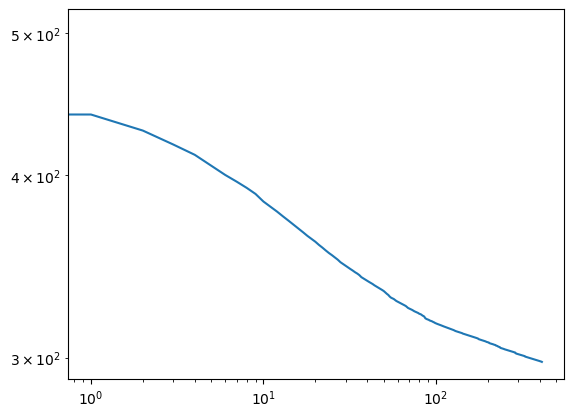

In [296]:
plt.plot(losses)
plt.yscale("log")
plt.xscale("log")

In [279]:
losses

[479.0408630371094,
 415.083251953125,
 402.955078125,
 394.0251770019531,
 387.2362976074219,
 382.2568359375,
 378.057861328125,
 374.81292724609375,
 372.02044677734375,
 369.39947509765625,
 367.0279235839844,
 364.9534912109375,
 363.0213623046875,
 361.11572265625,
 359.1021728515625,
 357.5810852050781,
 356.16705322265625,
 354.84002685546875,
 353.5376281738281,
 352.15948486328125,
 351.0406494140625,
 349.7974853515625,
 348.7527770996094,
 347.7410583496094,
 346.59625244140625,
 345.6877746582031,
 344.81219482421875,
 343.99053955078125,
 343.24932861328125,
 342.542236328125,
 341.8668212890625,
 341.1512145996094,
 340.4706115722656,
 339.7947082519531,
 339.1094055175781,
 338.204345703125,
 337.6746826171875,
 337.1651916503906,
 336.61932373046875,
 336.07562255859375,
 335.619140625,
 334.9723205566406,
 334.4668273925781,
 334.0527038574219,
 333.65216064453125,
 333.26446533203125,
 332.8583984375,
 332.2451477050781,
 331.7492370605469,
 331.32513427734375,
 330.

In [297]:
torch.sum(A_assignments_copy != A_assignments)/A_assignments.shape[0], torch.sum(B_assignments_copy != B_assignments)/B_assignments.shape[0]

(tensor(0.0005, device='cuda:6'), tensor(0.0003, device='cuda:6'))

In [134]:
calculate_loss(A_target, B_target, H/H.shape[0], weights)

(tensor(1.1442e+11, device='cuda:6'), tensor(1575160.6250, device='cuda:6'))

In [62]:
calculate_loss(A, B, H/H.shape[0], weights)

(tensor(0.1786, device='cuda:6'), tensor(0.0291, device='cuda:6'))

tensor([[-0.0096, -0.0301,  0.0085,  ...,  0.0178, -0.0052, -0.0365],
        [-0.0029, -0.0101,  0.0100,  ...,  0.0147,  0.0040, -0.0104],
        [-0.0004,  0.0139, -0.0074,  ..., -0.0083, -0.0070,  0.0146],
        ...,
        [-0.0107, -0.0061,  0.0310,  ..., -0.0052, -0.0143,  0.0236],
        [-0.0104, -0.0213, -0.0129,  ..., -0.0199, -0.0143, -0.0103],
        [ 0.0184,  0.0119,  0.0195,  ...,  0.0343, -0.0327, -0.0355]],
       device='cuda:6')

In [47]:
A @ B

tensor([[-1.4178e-02, -2.2208e-02,  5.4317e-03,  ...,  1.1174e-02,
         -1.2463e-02, -2.3007e-02],
        [-9.5070e-04, -2.4783e-05,  1.6815e-03,  ...,  2.7951e-03,
         -3.8319e-03, -5.3078e-03],
        [-2.3647e-03,  1.4799e-02,  3.5716e-04,  ..., -2.9102e-03,
         -2.0419e-03,  1.6440e-03],
        ...,
        [-1.7139e-02, -9.7607e-03,  3.3296e-02,  ..., -8.8332e-03,
         -1.0315e-02,  1.9540e-02],
        [-1.0282e-02, -2.2559e-02, -1.4939e-02,  ..., -1.9307e-02,
         -1.2256e-02, -7.1853e-03],
        [ 1.9854e-02,  9.5237e-03,  2.7221e-02,  ...,  2.2722e-02,
         -2.7219e-02, -2.6113e-02]], device='cuda:6')